# Stack Overflow Survey Analysis
Overall goal of this project is to get an understanding what do developers do to have the most successful career.

## 1. Data Preparation

### Load Packages

In [34]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ISLP as islp

### Create Functions

#### Probability Functions
- Create distributed data based on distribution function
- Fit data to existing PDF

In [35]:
import random

def generate_and_scale_distribution(distribution_func, dist_params, n, min_desired, max_desired, seed=None):
    """
    Generate n numbers from a specified distribution, scale them to a desired range, and plot the histogram.
    
    :param distribution_func: Function to generate random numbers from the desired distribution (e.g., random.gammavariate)
    :param dist_params: Parameters to pass to the distribution function (as a tuple)
    :param n: Number of values to generate
    :param min_desired: Minimum value of the desired range
    :param max_desired: Maximum value of the desired range
    :param seed: Seed for the random number generator (default is None)
    """
    
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
    
    # Generate numbers from the specified distribution
    dist_nums = [distribution_func(*dist_params) for _ in range(n)]
    
    # Scale the generated numbers to the desired range
    min_dist = min(dist_nums)
    max_dist = max(dist_nums)
    scaled_nums = [(num - min_dist) * (max_desired - min_desired) / (max_dist - min_dist) + min_desired for num in dist_nums]
    
    # Convert scaled numbers to integers
    int_scaled_nums = [int(num) for num in scaled_nums]

    return int_scaled_nums

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, gamma, uniform,poisson,beta
from sklearn.metrics import mean_absolute_error

def fit_and_plot_distributions(data, distributions, hist_bins=30):
    """
    Fit various distributions to the data, plot the results, and calculate SSE for each distribution.

    Parameters:
    data (array-like): The data to fit the distributions to.
    distributions (list): A list of distributions to fit.
    hist_bins (int): Number of bins for the histogram. Default is 30.

    Returns:
    dict: A dictionary with distribution names as keys and their corresponding SSE values.
    """
    # Create histogram of the data, adjusting 'density' to True for probability density
    counts, bins, _ = plt.hist(data, bins=hist_bins, density=True, color='lightblue', alpha=0.7, label='Histogram of data')

    # Create x values for plotting the PDF
    x = np.linspace(min(data), max(data), 1000)
    mae = {}  # Dictionary to store sum of squared errors for each distribution

    for distribution in distributions:
        # Fit distribution to data
        params = distribution.fit(data)

        # Separate parts of parameters: args (shape), loc (location), scale (scale)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate the PDF values for each x and for the bin centers
        pdf_values = distribution.pdf(x, *arg, loc=loc, scale=scale)
        estimated_pdf = distribution.pdf(bins[:-1] + np.diff(bins) / 2, *arg, loc=loc, scale=scale)

        # Adjust the estimated PDF by the bin widths to compute the SSE correctly
        bin_widths = np.diff(bins)
        adjusted_pdf = estimated_pdf * bin_widths

        # Calculate the SSE between the observed counts and the estimated PDF values
        mae[distribution.name] = mean_absolute_error(counts,estimated_pdf)

        # Plot the fitted distribution
        plt.plot(x, pdf_values, label=f'{distribution.name} fit')

    # Add plot formatting
    plt.title('Fit results for various distributions')
    plt.xlabel('Data values')
    plt.ylabel('Frequency')
    plt.legend()

    # Display the plot
    plt.show()

    return mae

#### OrgSize
Use the numerical increases to represent the size of the company increasing.

In [38]:
earnings_data['OrgSize'].unique()

NameError: name 'earnings_data' is not defined

In [ ]:
org_size_one_hot = [0,1,2,3,4,5,6,7,8,9,10,11]
org_size = ["I don't know",
            'Just me - I am a freelancer, sole proprietor, etc.',
            '2 to 9 employees',
            '10 to 19 employees',
            '20 to 99 employees',
            '100 to 499 employees',
            '500 to 999 employees',
            '1,000 to 4,999 employees',
            '5,000 to 9,999 employees',
            '10,000 or more employees']

org_size_mapping = dict(zip(org_size, org_size_one_hot))
earnings_data_one_hot['OrgSize'] = earnings_data['OrgSize'].map(org_size_mapping)

earnings_data_one_hot

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,"Senior Executive (C-Suite, VP, etc.)",2.0,United States of America,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,"Developer, back-end",8.0,United States of America,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,"Developer, front-end",5.0,United States of America,NaN,156000.0
5,NaN,4,6,"Developer, full-stack",4.0,Philippines,Other,23456.0
6,NaN,21,21,"Developer, back-end",5.0,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,"Developer, back-end",8.0,Brazil,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,"Developer, full-stack",4.0,Armenia,Financial Services,16917.0
89168,NaN,2,6,"Developer, mobile",4.0,India,Retail and Consumer Services,15752.0


#### DevType
To reduce the complicated nature of having 33 different parameter outputs, these can be reduced to more broad terms such as 
- Software Developer
- Data and AI Professionals
- Engineering and Operations
- Management and Leadership
- Academic and Research
- Other

In [ ]:
# get all of the unique values
earnings_data['DevType'].unique()

array(['Senior Executive (C-Suite, VP, etc.)', 'Developer, back-end',
       'Developer, front-end', 'Developer, full-stack',
       'System administrator', 'Developer, QA or test', 'Designer',
       'Data scientist or machine learning specialist',
       'Data or business analyst', 'Security professional',
       'Research & Development role', 'Developer, mobile',
       'Database administrator',
       'Developer, embedded applications or devices',
       'Developer, desktop or enterprise applications', 'Engineer, data',
       'Product manager', 'Academic researcher',
       'Cloud infrastructure engineer', 'Other (please specify):',
       'Developer Experience', 'Engineering manager', 'DevOps specialist',
       'Engineer, site reliability', 'Project manager', 'Blockchain', nan,
       'Developer, game or graphics', 'Developer Advocate',
       'Hardware Engineer', 'Educator', 'Scientist',
       'Marketing or sales professional', 'Student'], dtype=object)

In [ ]:
# create a dictionary to create new Developer Types
# Define the mapping dictionary
dev_type_mapping = {
    'Developer, full-stack': 'Software Developer',
    'Developer, back-end': 'Software Developer',
    'Developer, front-end': 'Software Developer',
    'Developer, desktop or enterprise applications': 'Software Developer',
    'Developer, mobile': 'Software Developer',
    'Developer, embedded applications or devices': 'Software Developer',
    'Developer, game or graphics': 'Software Developer',
    'Developer, QA or test': 'Software Developer',

    'Data scientist or machine learning specialist': 'Data and AI Professionals',
    'Engineer, data': 'Data and AI Professionals',
    'Data or business analyst': 'Data and AI Professionals',

    'DevOps specialist': 'Engineering and Operations',
    'System administrator': 'Engineering and Operations',
    'Engineer, site reliability': 'Engineering and Operations',
    'Cloud infrastructure engineer': 'Engineering and Operations',
    'Security professional': 'Engineering and Operations',
    'Blockchain': 'Engineering and Operations',
    'Hardware Engineer': 'Engineering and Operations',
    'Database administrator': 'Engineering and Operations',

    'Engineering manager': 'Management and Leadership',
    'Senior Executive (C-Suite, VP, etc.)': 'Management and Leadership',
    'Project manager': 'Management and Leadership',
    'Product manager': 'Management and Leadership',

    'Academic researcher': 'Academic and Research',
    'Scientist': 'Academic and Research',
    'Research & Development role': 'Academic and Research',
    'Student': 'Academic and Research',

    'Developer Advocate': 'Others',
    'Developer Experience': 'Others',
    'Designer': 'Others',
    'Educator': 'Others',
    'Marketing or sales professional': 'Others',
    'Other (please specify):': 'Others'
}

In [ ]:
# function to map multiple dev types in a single row
def map_dev_type(dev_type_str):
    dev_types = dev_type_str.split('; ')
    mapped_types = [dev_type_mapping.get(dev_type, 'Others') for dev_type in dev_types]
    return '; '.join(mapped_types)

# apply the mapping to the DevType column
earnings_data_one_hot['DevType'] = earnings_data['DevType'].dropna().apply(map_dev_type)

earnings_data_one_hot

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,Management and Leadership,2.0,United States of America,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,Software Developer,8.0,United States of America,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,Software Developer,5.0,United States of America,NaN,156000.0
5,NaN,4,6,Software Developer,4.0,Philippines,Other,23456.0
6,NaN,21,21,Software Developer,5.0,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,Software Developer,8.0,Brazil,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,Software Developer,4.0,Armenia,Financial Services,16917.0
89168,NaN,2,6,Software Developer,4.0,India,Retail and Consumer Services,15752.0


#### Country
Due to the number of countries and the higher concentration create a variable that is US/Not US

In [ ]:
usa_mask = earnings_data_one_hot['Country']=='United States of America'
usa_mask

ResponseId
2         True
3         True
4         True
5        False
6        False
         ...  
89163    False
89167    False
89168    False
89171    False
89172    False
Name: Country, Length: 48019, dtype: bool

In [ ]:
earnings_data_one_hot['Country'][usa_mask] = 1
earnings_data_one_hot['Country'][~usa_mask] = 0

earnings_data_one_hot

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_42554/3302318340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data_one_hot['Country'][usa_mask] = 1
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_42554/3302318340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data_one_hot['Country'][~usa_mask] = 0


,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,Management and Leadership,2.0,1,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,Software Developer,8.0,1,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,Software Developer,5.0,1,NaN,156000.0
5,NaN,4,6,Software Developer,4.0,0,Other,23456.0
6,NaN,21,21,Software Developer,5.0,0,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,Software Developer,8.0,0,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,Software Developer,4.0,0,Financial Services,16917.0
89168,NaN,2,6,Software Developer,4.0,0,Retail and Consumer Services,15752.0


In [ ]:
linear_regression_data_salary = convert_to_dummies(earnings_data_one_hot,['DevType','Industry'])

### Data Pre-Processing

In [ ]:
# observe the different data types
earnings_data.dtypes

EdLevel                 object
YearsCodePro            object
YearsCode               object
DevType                 object
OrgSize                 object
Country                 object
Industry                object
ConvertedCompYearly    float64
dtype: object

#### Transforming 'YearsCode' and 'YearsCodePro'
Make 'YearsCode' and 'YearsCodePro' as 'int' dtypes rather than 'object'.
- YearsCode is the number of years that someone has been coding without being paid for it
- YearsCodePro is the number of years that someone has been coding and has been paid for their work

In [ ]:
# observe YearsCode and YearsCodePro
earnings_data[['YearsCode','YearsCodePro']].head(10)

,YearsCode,YearsCodePro
ResponseId,,
2,18,9
3,27,23
4,12,7
5,6,4
6,21,21
7,4,3
8,5,3
9,20,15
12,10,9


##### YearsCode

In [ ]:
# look at 
earnings_data['YearsCode'].unique()

array(['18', '27', '12', '6', '21', '4', '5', '20', '10', '15', '11', '3',
       '24', '8', '13', 'Less than 1 year', '16', '33', '22', '32', '35',
       '7', '29', '19', 'More than 50 years', '38', '26', '34', '14', '9',
       '2', '23', '30', '40', '25', '45', '31', '43', '17', '28', '41',
       '39', '48', '42', '37', '36', '1', '44', '46', nan, '49', '47',
       '50'], dtype=object)

In order to convert from 'object' dtype to 'int' the removal of 'Less than 1 year' and 'More than 50 years' is neccessary. 

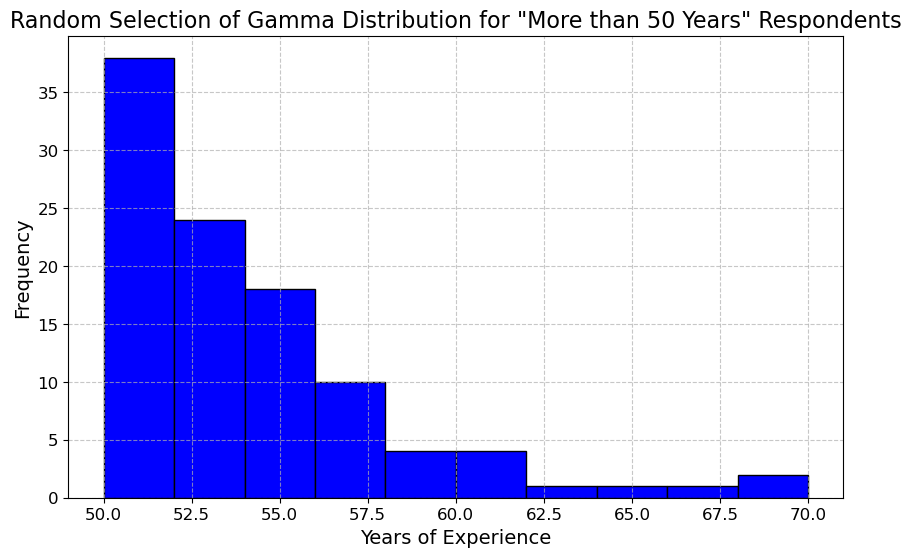

In [ ]:
# create new values for 'more than 50 years' response
# ensuring that the number of gamma values is equal to the number of respondents who had 'More than 50 years'
# output them
more_than_50_new_values = generate_and_scale_distribution(random.gammavariate,(1,1),
                                                          len(earnings_data[earnings_data['YearsCode']=='More than 50 years'])
                                                          ,50,70,30)
plot_histogram(more_than_50_new_values,10,'Random Selection of Gamma Distribution for "More than 50 Years" Respondents','Years of Experience','Frequency')

In [ ]:
# allocate the new values to the old values 
# this is done so that YearsCode is now an 'int' data type
more_than_50_old_values = earnings_data['YearsCode']=='More than 50 years'
earnings_data.loc[more_than_50_old_values, 'YearsCode'] = more_than_50_new_values

In [ ]:
# replace less than 1 year with 1 year of experience
less_than_1_old_values = earnings_data['YearsCode'] == 'Less than 1 year'
earnings_data.loc[less_than_1_old_values,'YearsCode'] = 1

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_42554/2465112585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data['YearsCode'] = earnings_data['YearsCode'].dropna().astype(int)


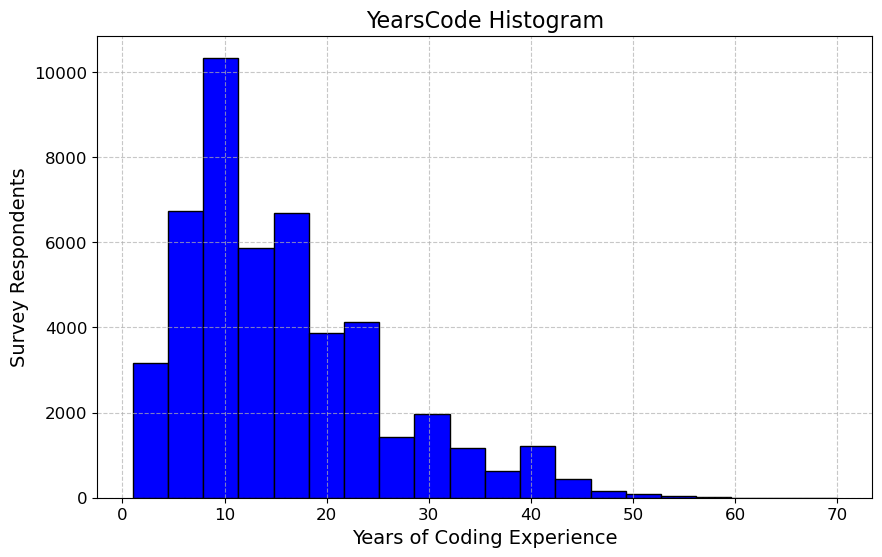

In [ ]:
# change the datatype to int
# dropping the na when changing to int allows to not have to remove all NA
# this ensures data integrity
earnings_data['YearsCode'] = earnings_data['YearsCode'].dropna().astype(int)

# plot histogram
plot_histogram(earnings_data['YearsCode'],20,'YearsCode Histogram','Years of Coding Experience','Survey Respondents')

The data looks to have uniform distribution or gamma distribution, fit the data to those distributions to see which has a lower error value.

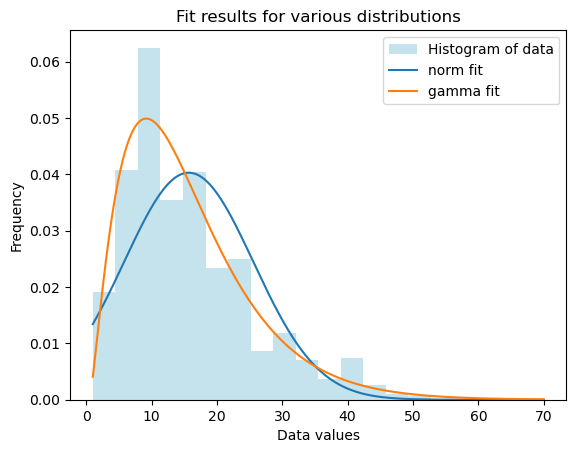

{'norm': 0.00460409547891067, 'gamma': 0.0028768146982904464}

In [ ]:
# fit the YearsCode data with a given PDF
from scipy.stats import uniform
fit_and_plot_distributions(earnings_data['YearsCode'].dropna(),[norm,gamma],20) 

YearsPro data fits a gamma distribution by the values that have been produced and the movement of the data in the graph.

##### YearsCodePro

In [ ]:
# understand the different outcomes
earnings_data['YearsCodePro'].unique()

array(['9', '23', '7', '4', '21', '3', '15', 'Less than 1 year', '10',
       '2', '6', '14', '5', '19', '13', '16', '28', '30', '11', '8', '24',
       '40', '17', '29', '25', '12', '20', '18', '50', '27', '43', '26',
       '1', '38', '33', '22', '35', nan, '31', '34', '32', '37', '42',
       'More than 50 years', '36', '39', '41', '44', '48', '45', '46',
       '47', '49'], dtype=object)

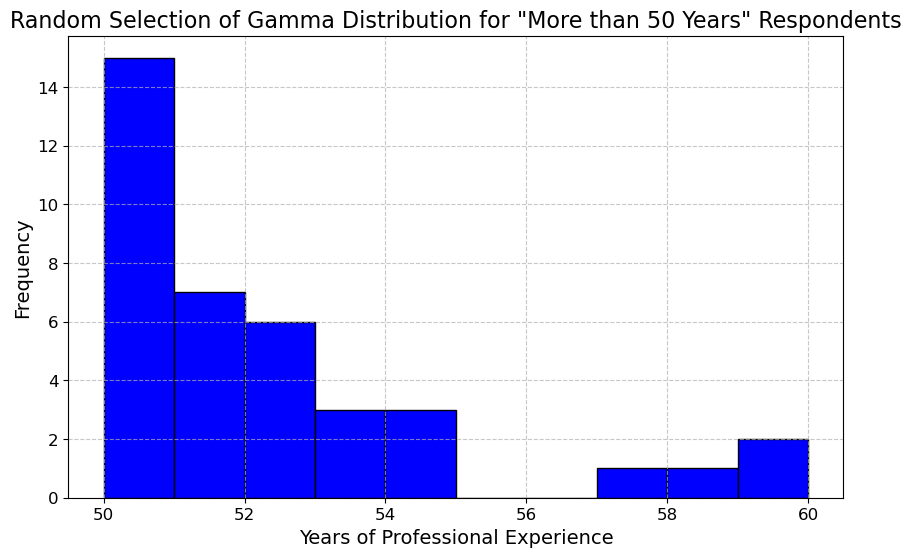

In [ ]:
# create new values for 'more than 50 years' response
# a maximum of 60 years of professional coding has been put on the data to accurately reflect reality
more_than_50_new_values_pro = generate_and_scale_distribution(random.gammavariate,(1,1),
                                                          len(earnings_data[earnings_data['YearsCodePro']=='More than 50 years'])
                                                          ,50,60,30)
plot_histogram(more_than_50_new_values_pro,10,'Random Selection of Gamma Distribution for "More than 50 Years" Respondents','Years of Professional Experience','Frequency')

In [ ]:
# allocate the new values to the old values 
# this is done so that YearsCode is now an 'int' data type
more_than_50_old_values_pro = earnings_data['YearsCodePro']=='More than 50 years'
earnings_data.loc[more_than_50_old_values_pro, 'YearsCodePro'] = more_than_50_new_values_pro

In [ ]:
# replace less than 1 year with 1 year of experience
less_than_1_old_values_pro = earnings_data['YearsCodePro'] == 'Less than 1 year'
earnings_data.loc[less_than_1_old_values_pro,'YearsCodePro'] = 1

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_42554/2853971813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data['YearsCodePro'] = earnings_data['YearsCodePro'].dropna().astype(int)


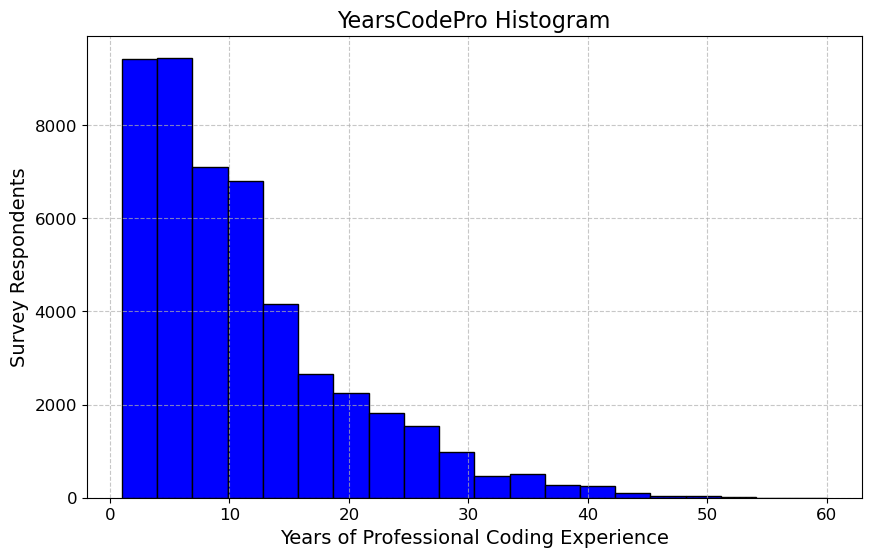

In [ ]:
# change the datatype to int
# dropping the na when changing to int allows to not have to remove all NA
# this ensures data integrity
earnings_data['YearsCodePro'] = earnings_data['YearsCodePro'].dropna().astype(int)

# plot histogram
plot_histogram(earnings_data['YearsCodePro'],20,'YearsCodePro Histogram','Years of Professional Coding Experience','Survey Respondents')

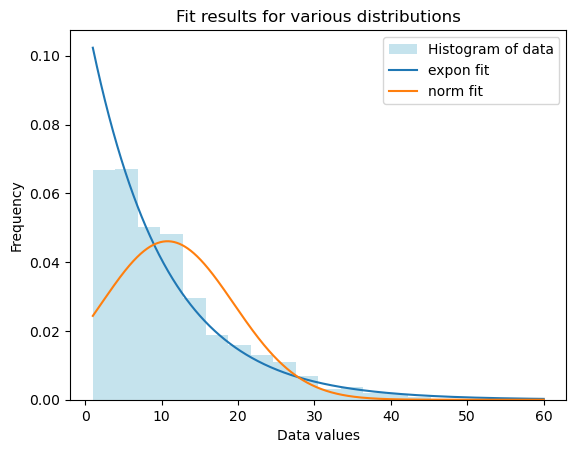

{'expon': 0.002717367940146757, 'norm': 0.006419788993686955}

In [ ]:
# fit the data to different distributions
fit_and_plot_distributions(earnings_data['YearsCodePro'].dropna(),[expon,norm],20) 

In [ ]:
linear_regression_data_salary

,EdLevel,YearsCodePro,YearsCode,OrgSize,Country,ConvertedCompYearly,Not-DevType,DevType,Engineering and Operations,Management and Leadership,Others,Software Developer,Not-Industry,Industry,Healthcare,Higher Education,"Information Services, IT, Software Development, or other Technology",Insurance,Legal Services,"Manufacturing, Transportation, or Supply Chain",Oil & Gas,Other,Retail and Consumer Services,Wholesale
ResponseId,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,9,18,2.0,1,285000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,NaN,23,27,8.0,1,250000.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,NaN,7,12,5.0,1,156000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,NaN,4,6,4.0,0,23456.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,NaN,21,21,5.0,0,96828.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89163,NaN,24,30,8.0,0,50719.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
89167,NaN,2,7,4.0,0,16917.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
89168,NaN,2,6,4.0,0,15752.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


YearsCodePro fits the distribution of exponential the best.

In [ ]:
import ISLP
X = linear_regression_data_salary.drop(columns='Salary').fit_transform()

AttributeError: 'DataFrame' object has no attribute 'fit_transform'

In [ ]:
# rename column
earnings_data.rename(columns={'Salary':'Salary'},inplace=True)

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_63159/3143130971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data.rename(columns={'ConvertedCompYearly':'Salary'},inplace=True)


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff1d27c2310>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff1d27c28b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff1d27c2040>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff1d27c2e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff1d27cc160>],
 'means': []}

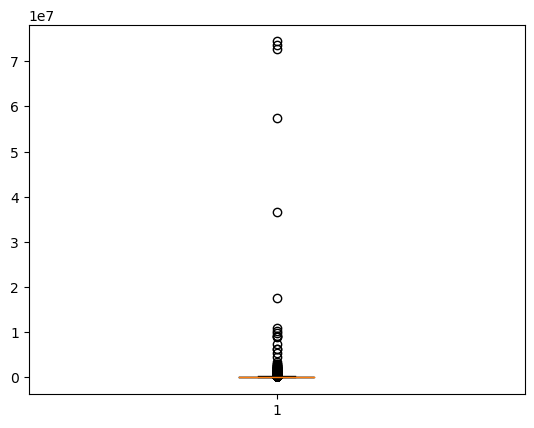

In [ ]:
# create a histogram for earners
plt.boxplot(earnings_data['Salary'])

In [ ]:
# calculate the mean and the median
mean_salary = earnings_data['Salary'].mean()
median_salary = earnings_data['Salary'].median()

# display the mean and median
print(f'The mean salary for respondents is {mean_salary}')
print(f'The median salary for the respondents is {median_salary}')

The mean salary for respondents is 103110.08171765343
The median salary for the respondents is 74963.0


There is clearly some outliers that are making the interpretation of the data difficult. This is further proved by the mean salary being about $25k more than the median salary. Removing this data will make for a better overall understanding of the survey respondents.

Remove those earning more than $10 million a year and those earning less than $20k a year

In [ ]:
# remove the extremely high earning individuals
low_earnings_mask = earnings_data['Salary'] < 20000
high_earnings_mask = earnings_data['Salary'] > 10000000

# use both masks to remove those earning less than $20k and those earning more than $10m
extreme_earnings = low_earnings_mask | high_earnings_mask

# remove the extreme earnings value
earnings_data = earnings_data[~extreme_earnings]

In [ ]:
earnings_data.corr()

,YearsCodePro,YearsCode,Salary
YearsCodePro,1.000000,0.911018,0.131529
YearsCode,0.911018,1.000000,0.125669
Salary,0.131529,0.125669,1.000000


#### Highest Earners
Looking at the top 0.03% of respondents based on salary using z-scores of at least 3.